# Midterm Project (Volve Dataset)
## Facies classification using Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

import warnings
warnings.filterwarnings("ignore")

## 1. Load, Visualization and Exploration of Data

### 1.1. Data Load

In [2]:
#Load data
well_13 = pd.read_excel('VolveData_Project.xlsx', sheet_name='well 13',index_col=0)
well_14 = pd.read_excel('VolveData_Project.xlsx', sheet_name='well 14')
well_15 = pd.read_excel('VolveData_Project.xlsx', sheet_name='well 15')

In [3]:
data = pd.concat([well_14, well_15], axis=0)
data['Well'] = data['Well'].astype('category')
data['RT_log'] = np.log10(data.RT) #For Visualization
data

,Depth,Well,GR,RT,RHOB,NPHI,Facies,RT_log
0,3178.5,14,50.2190,0.5888,2.3296,0.3657,SH,-0.230032
1,3179.0,14,47.2468,0.7768,2.3170,0.3776,UN,-0.109691
2,3179.5,14,49.5247,1.0707,2.2960,0.5390,SH,0.029668
3,3180.0,14,44.9124,1.4460,2.2514,0.5482,UN,0.160168
4,3180.5,14,47.0048,0.9542,2.2733,0.5076,UN,-0.020361
...,...,...,...,...,...,...,...,...
1154,4083.5,15,59.7060,1.7590,2.4851,0.1416,CB,0.245266
1155,4084.0,15,58.4170,1.6510,2.4860,0.1416,CB,0.217747
1156,4084.5,15,57.4990,1.5970,2.5311,0.1527,CB,0.203305
1157,4085.0,15,56.7850,1.4820,2.4731,0.1785,CB,0.170848


### 1.2. Visualization

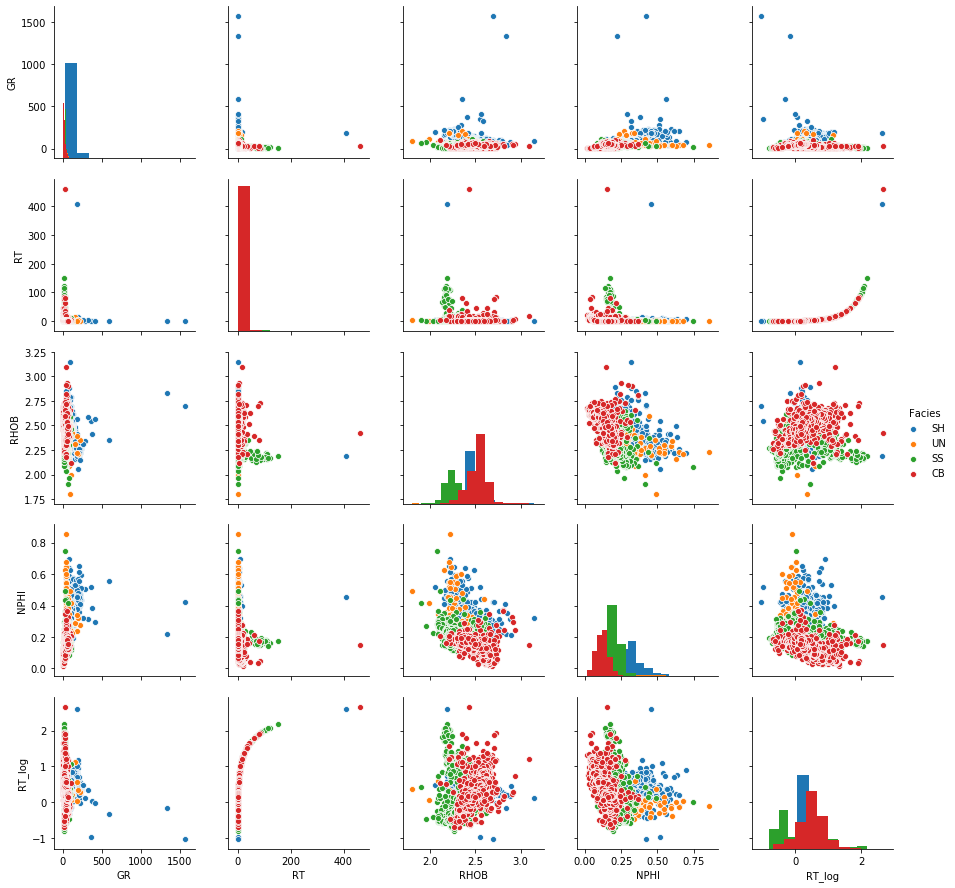

In [4]:
sns.pairplot(data.drop(['Well','Depth'], axis = 1) ,hue='Facies',diag_kind='hist')

#### Well logs plot

In [5]:
labels = [1,2,3,4] 
data['Facies_Label']=np.select([data['Facies'] == 'SH',
                                data['Facies'] == 'UN',
                                data['Facies'] == 'SS',
                                data['Facies'] == 'CB',]
                                ,labels)

In [6]:
facies_colors = ['#2E86C1', '#196F3D','#F4D03F','#DC7633']

facies = ['SH', 'UN', 'SS', 'CB']

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies_Label'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.RT_log, logs.Depth, '-')
    ax[2].plot(logs.NPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.Depth, '-', color='r')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                   cmap=cmap_facies,vmin=1,vmax=4)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((50*' ').join(['SH', 'UN', 'SS', 'CB']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("RT")
    ax[1].set_xlim(logs.RT_log.min(),logs.RT_log.max())
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(logs.NPHI.min(),logs.NPHI.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[4].set_yticklabels([])
    ax[4].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well'], fontsize=14,y=0.94)

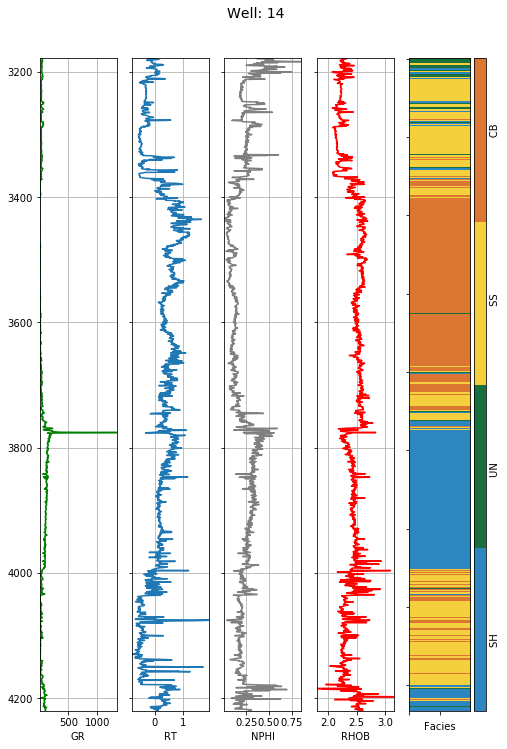

In [7]:
make_facies_log_plot(data[data['Well'] == 14],facies_colors)

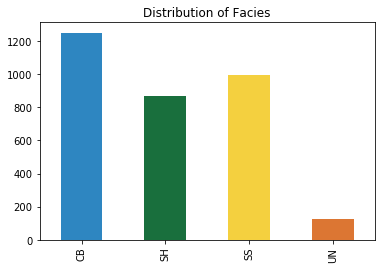

In [8]:
#Bar chart: Distribution of Facies
Facies_dist = data['Facies'].value_counts().sort_index()

Facies_dist.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Facies')

### 1.3. Exploration

In [9]:
#Set Index Depth
data.set_index('Depth',inplace=True)

In [10]:
#Group by Well Name
data.groupby("Well").count()

,GR,RT,RHOB,NPHI,Facies,RT_log,Facies_Label
Well,,,,,,,
14,2082,2082,2082,2082,2082,2082,2082
15,1159,1159,1159,1159,1159,1159,1159


In [11]:
#Data Info (For dtype and NaN analysis)
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3241 entries, 3178.5 to 4085.5
Data columns (total 8 columns):
Well            3241 non-null category
GR              3241 non-null float64
RT              3241 non-null float64
RHOB            3241 non-null float64
NPHI            3241 non-null float64
Facies          3241 non-null object
RT_log          3241 non-null float64
Facies_Label    3241 non-null int32
dtypes: category(1), float64(5), int32(1), object(1)
memory usage: 193.2+ KB


In [12]:
data.describe()

,GR,RT,RHOB,NPHI,RT_log,Facies_Label
count,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000,3241.000000
mean,51.379917,4.292569,2.432688,0.207456,0.278370,2.809627
std,57.700965,14.524740,0.147662,0.104241,0.487116,1.209471
min,3.655000,0.094000,1.805100,0.013500,-1.026872,1.000000
25%,17.433000,1.014000,2.311000,0.133600,0.006038,1.000000
50%,34.083600,1.864900,2.459000,0.187900,0.270656,3.000000
75%,71.846000,3.697700,2.550000,0.267500,0.567932,4.000000
max,1567.590000,461.170000,3.149300,0.853200,2.663861,4.000000


In [13]:
X = data.drop(['Facies','Well','Facies_Label','RT_log'], axis = 1) #Features: Feature vector
y = data['Facies'] #Target: Facies

## 2. Data Split (Test/Train)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)
print('Dimensions of X_train:',X_train.shape)
print('Dimensions of X_test:',X_test.shape)

Dimensions of X_train: (2268, 4)
Dimensions of X_test: (973, 4)


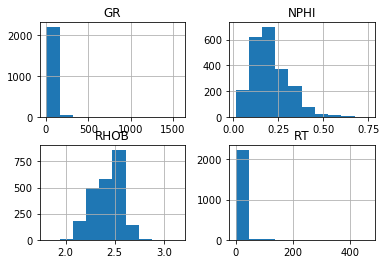

In [15]:
X_train.hist()
plt.show()

In [16]:
X_test

,GR,RT,RHOB,NPHI
Depth,,,,
3281.0,51.3597,0.6210,2.1899,0.3108
4217.5,102.8300,0.9319,2.6062,0.1316
3640.0,32.3120,2.8370,2.6359,0.1477
4152.5,21.3774,0.2730,2.2880,0.1866
4088.0,22.1788,0.3589,2.2902,0.1883
...,...,...,...,...
3699.5,184.3600,1.0980,2.2141,0.3384
3822.5,154.8366,2.2770,2.3451,0.3593
3789.0,84.9310,1.7140,2.4610,0.2864


## 3. Data Preprocessing

### 3.1. Feature Transform: Robust Scaler

In [17]:
# Robust Scaler
rscaler = RobustScaler() #instantiate
rscaler.fit(X_train) 

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [18]:
X_train_scaled = rscaler.transform(X_train) # transform the train dataset to standardized data

# Original training dataset
print("Original median : %s " % rscaler.center_)
print("Original IQR : %s " % rscaler.scale_)

#Scaled training dataset
print("Scaled median : %s " % np.median(X_train_scaled,axis=0))
print("Scaled IQR : %s " % (np.percentile(X_train_scaled, 75,axis=0)-np.percentile(X_train_scaled, 25,axis=0)))

Original median : [33.7498  1.8525  2.458   0.1876] 
Original IQR : [50.22925   2.7383    0.23975   0.131825] 
Scaled median : [0. 0. 0. 0.] 
Scaled IQR : [1. 1. 1. 1.] 


In [19]:
#Scale the test data using the parameters learnt from the training dataset
X_test_scaled  = rscaler.transform(X_test)

print("Median of scaled test data: %s" % np.median(X_test_scaled,axis=0))
print("IQR of scaled test data: %s " % (np.percentile(X_test_scaled, 75,axis=0)-np.percentile(X_test_scaled, 25,axis=0)))

Median of scaled test data: [0.02342858 0.01150349 0.00834202 0.00758581]
IQR of scaled test data: [1.24073722 0.92243363 0.98435871 1.06125545] 


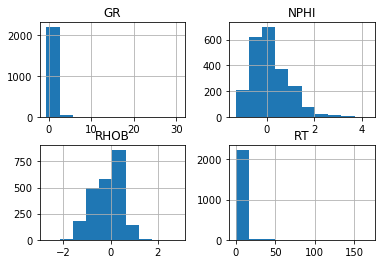

In [20]:
pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns).hist()
plt.show()

In [21]:
X_train=pd.DataFrame(X_train_scaled,index=X_train.index, columns=X_test.columns)
X_test=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_test.columns)
X_test

,GR,RT,RHOB,NPHI
Depth,,,,
3281.0,0.350591,-0.449732,-1.118248,0.934572
4217.5,1.375298,-0.336194,0.618144,-0.424806
3640.0,-0.028625,0.359530,0.742023,-0.302674
4152.5,-0.246319,-0.576818,-0.709072,-0.007586
4088.0,-0.230364,-0.545448,-0.699896,0.005310
...,...,...,...,...
3699.5,2.998456,-0.275536,-1.017310,1.143941
3822.5,2.410683,0.155023,-0.470907,1.302484
3789.0,1.018952,-0.050579,0.012513,0.749478


### 3.2. Outlier Detection: Isolation Forest

In [22]:
# Isolation Forest
iforest = IsolationForest(n_estimators=200, contamination=0.5/100)
iforest = iforest.fit(X_train) #Training the model

In [23]:
#Predictions
X_train_predict = iforest.predict(X_train) 
X_train['Predict']=X_train_predict
X_train['Predict'] = X_train['Predict'].astype('category')
X_train

,GR,RT,RHOB,NPHI,Predict
Depth,,,,,
3958.0,1.255792,-0.160465,-0.045881,0.766167,1
3350.0,-0.085538,-0.555308,-1.136601,0.332259,1
3469.0,-0.553492,1.884563,0.608968,-0.936090,1
3885.5,1.832361,-0.145857,0.008342,1.140907,1
3867.0,-0.214751,31.833072,-1.184150,0.040963,1
...,...,...,...,...,...
3865.5,1.757852,-0.166015,0.009593,0.367153,1
3663.0,0.456133,0.042545,0.282795,-0.055376,1
3518.5,-0.375056,0.088924,0.220647,-0.364119,1


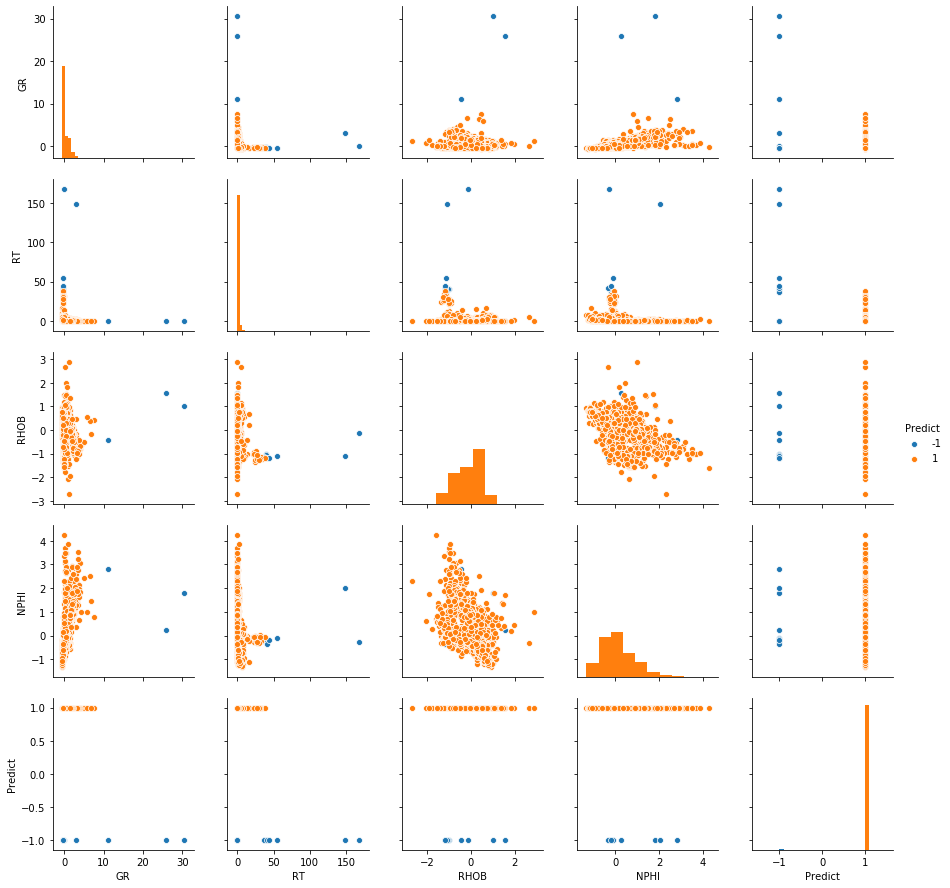

In [24]:
#Visualization
sns.pairplot(X_train,hue='Predict',diag_kind='hist')

In [25]:
#Removing Outliers
X_train['y_train']=y_train
X_train = X_train[X_train['Predict'] == 1]

y_train=X_train['y_train']
X_train = X_train.drop(['Predict','y_train'], axis = 1)

In [26]:
print(len(X_train))
print(len(y_train))

2256
2256


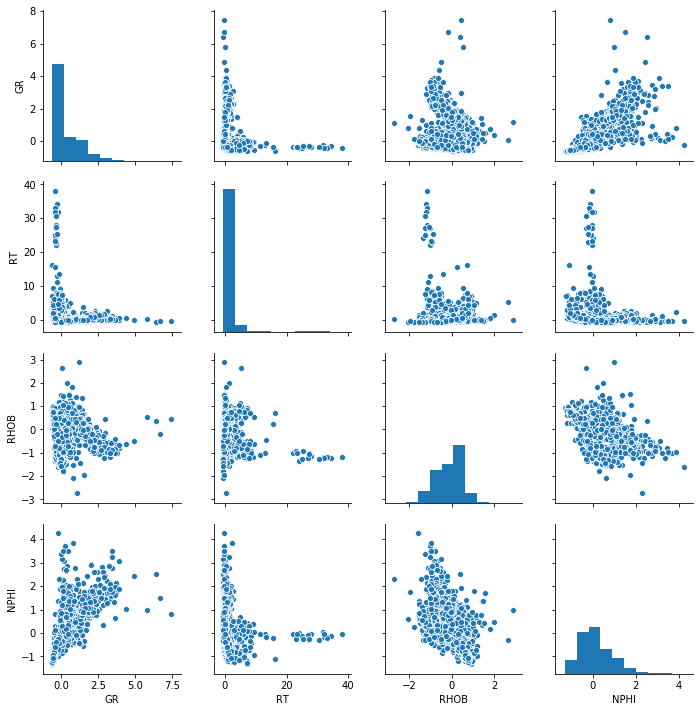

In [27]:
#Visualization Without Outliers
sns.pairplot(X_train,diag_kind='hist')

## 4. Models

### 4.1. Logistic Regression

#### Tuning Hyperparameters

In [28]:
score=[]
score_train=[]
C=[]
for i in range(1,200,10):
    C.append(i/10)
    classifier = LogisticRegression(penalty='l2',C=i/10) 
    classifier.fit(X_train, y_train)
    train_pred = classifier.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = classifier.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

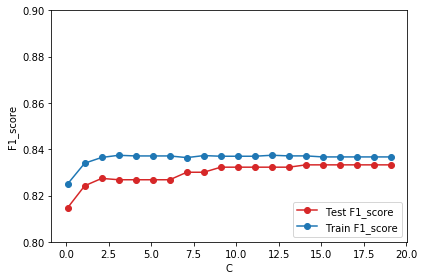

In [29]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('C')
ax1.set_ylabel('F1_score')
ax1.set_ylim([0.8,0.9])
ax1.plot(C, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(C, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Applying Model

In [30]:
classifier = LogisticRegression(C=12) 
classifier.fit(X_train, y_train)

print(classifier.coef_) #a1 and a2
print(classifier.intercept_) # a0

[[-3.67307764  0.28727041  0.27900854 -4.28729421]
 [ 4.92799193 -0.55591228  1.50335816  2.85310776]
 [-2.78795679  0.35140617 -1.50503019 -0.16071646]
 [ 1.5330425  -0.08276431 -0.2773365   1.5949029 ]]
[ 1.75857297 -2.9716961   2.12144189 -0.90831875]


In [31]:
prediction = classifier.predict(X_test)

In [32]:
#Compare against true labels (Accuracy)
print('Accuracy (generalization)',classifier.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',classifier.score(X_train,y_train)) #Accuracy (memorization)

Accuracy (generalization) 0.8437821171634121
Accuracy (memorization) 0.8497340425531915


In [33]:
#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,classifier.predict(X_test),average="weighted")) #Accuracy (generalization)  
print('F1_score (memorization)',f1_score(y_train,classifier.predict(X_train),average="weighted")) #Accuracy (memorization)    

F1_score (generalization) 0.8322486625710824
F1_score (memorization) 0.8374033828971233


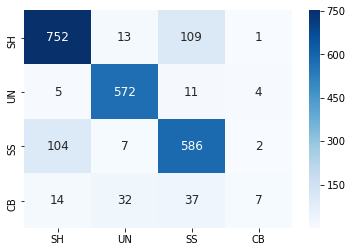

In [34]:
#Confusion Matrix
names = ['SH', 'UN', 'SS', 'CB']

cf_matrix = confusion_matrix(y_train, classifier.predict(X_train))

cf=sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names)

plt.show()

### 4.2. K-Nearest Neighbor

#### Tuning Hyperparameters

In [35]:
#Number of trees
score_gen=[]
score_mem=[]
n_neighbors=[]
for i in range(1,22,2):
    n_neighbors.append(i)
    knn = KNeighborsClassifier(n_neighbors=i,p=1)    #Creating Instance
    knn.fit(X_train, y_train) #Learning the decision boundaries
    train_pred = knn.predict(X_train)
    score_mem.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = knn.predict(X_test)
    score_gen.append(f1_score(y_test, y_pred,average="weighted"))

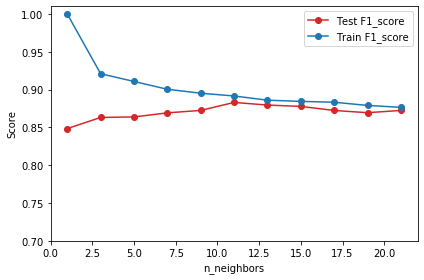

In [36]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('n_neighbors')
ax1.set_ylabel('Score')
ax1.set_ylim([0.7,1.01])
ax1.plot(n_neighbors, score_gen, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(n_neighbors, score_mem, '-o',color=color,label='Train F1_score')

ax1.legend(loc="Upper right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [37]:
#Proximity (p)
score_gen=[]
score_mem=[]
prox=[]
for i in range(1,20,1):
    prox.append(i)
    knn = KNeighborsClassifier(n_neighbors=11,p=i)    #Creating Instance
    knn.fit(X_train, y_train) #Learning the decision boundaries
    train_pred = knn.predict(X_train)
    score_mem.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = knn.predict(X_test)
    score_gen.append(f1_score(y_test, y_pred,average="weighted"))

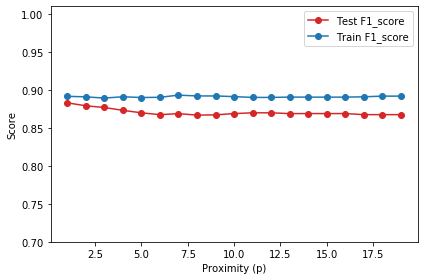

In [38]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Proximity (p)')
ax1.set_ylabel('Score')
ax1.set_ylim([0.7,1.01])
ax1.plot(prox, score_gen, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(prox, score_mem, '-o',color=color,label='Train F1_score')

ax1.legend(loc="Upper right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Applying Model

In [39]:
knn = KNeighborsClassifier(n_neighbors=11,p=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=1,
                     weights='uniform')

In [40]:
#Compare against true labels (Accuracy)
print('Accuracy (generalization)',knn.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',knn.score(X_train,y_train)) #Accuracy (memorization)

Accuracy (generalization) 0.8838643371017472
Accuracy (memorization) 0.8940602836879432


In [41]:
#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,knn.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,knn.predict(X_train),average="weighted")) #F1_score (memorization

F1_score (generalization) 0.8830494601752273
F1_score (memorization) 0.89157835690532


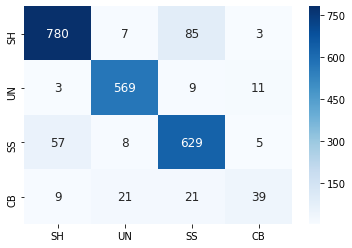

In [42]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_train, knn.predict(X_train))

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names) 

plt.show()

### 4.3. Support Vector Machine

#### Tuning Hyperparameters

In [43]:
from sklearn.model_selection import GridSearchCV 
  
#Defining parameter range 
Tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'],'C': [1, 10, 100, 1000],'degree': [2,3,4]}]
  
svc_mod = GridSearchCV(SVC(), Tuned_parameters, refit = True, verbose = 3) 

In [44]:
svc_mod.fit(X_train, y_train) 
svc_mod.best_estimator_

Fitting 5 folds for each of 41 candidates, totalling 205 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.847, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.869, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.851, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.860, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.834, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.821, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.829, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.831, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.843, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.845, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.858, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.840, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.830, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.840, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.845, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.838, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.856, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.845, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.843, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.865, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.843, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.854, total=   0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.843, total=   0.0s
[CV] C=10, kernel=linear .............................................
[CV] .

[CV] ........ C=100, degree=3, kernel=poly, score=0.814, total=   0.3s
[CV] C=100, degree=3, kernel=poly ....................................
[CV] ........ C=100, degree=3, kernel=poly, score=0.827, total=   0.5s
[CV] C=100, degree=3, kernel=poly ....................................
[CV] ........ C=100, degree=3, kernel=poly, score=0.836, total=   0.3s
[CV] C=100, degree=3, kernel=poly ....................................
[CV] ........ C=100, degree=3, kernel=poly, score=0.831, total=   0.1s
[CV] C=100, degree=4, kernel=poly ....................................
[CV] ........ C=100, degree=4, kernel=poly, score=0.721, total=   0.2s
[CV] C=100, degree=4, kernel=poly ....................................
[CV] ........ C=100, degree=4, kernel=poly, score=0.736, total=   1.1s
[CV] C=100, degree=4, kernel=poly ....................................
[CV] ........ C=100, degree=4, kernel=poly, score=0.738, total=   3.2s
[CV] C=100, degree=4, kernel=poly ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 205 out of 205 | elapsed:  2.9min finished


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
print(svc_mod.best_params_) 

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [46]:
#Performance (Accuracy)
print('Accuracy (generalization)',svc_mod.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',svc_mod.score(X_train,y_train)) #Accuracy (memorization)

#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,svc_mod.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,svc_mod.predict(X_train),average="weighted")) #F1_score (memorization) 

Accuracy (generalization) 0.869475847893114
Accuracy (memorization) 0.8914007092198581
F1_score (generalization) 0.8679928576028597
F1_score (memorization) 0.8898922984625451


#### Applying Model

In [47]:
srbf=SVC(C=100,kernel='rbf',gamma=0.1)
srbf.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
#Performance (Accuracy)
print('Accuracy (generalization)',srbf.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',srbf.score(X_train,y_train)) #Accuracy (memorization)

#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,srbf.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,srbf.predict(X_train),average="weighted")) #F1_score (memorization) 

Accuracy (generalization) 0.869475847893114
Accuracy (memorization) 0.8914007092198581
F1_score (generalization) 0.8679928576028597
F1_score (memorization) 0.8898922984625451


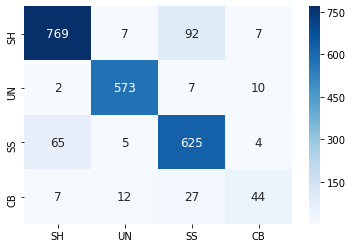

In [49]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_train, srbf.predict(X_train))

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names)

plt.show()

### 4.4. Random Forest

#### Tuning Hyperparameters

In [50]:
#Number of trees
score=[]
t=[]
n_trees=[]
for i in range(10,300,10):
    n_trees.append(i)
    start_time = time.time()
    cforest = RandomForestClassifier(criterion='entropy',n_estimators=i,max_depth=5,random_state=1, n_jobs=2) #Creating Instance
    cforest.fit(X_train, y_train) #Learning the decision boundaries
    y_pred = cforest.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))
    t.append(time.time() - start_time)

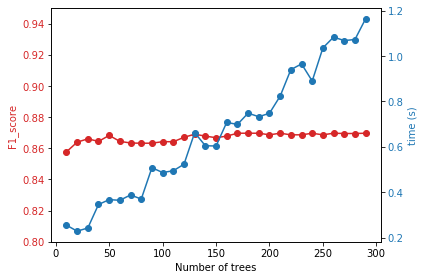

In [51]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of trees')
ax1.set_ylabel('F1_score', color=color)
ax1.set_ylim([0.8,0.95])
ax1.plot(n_trees, score, '-o',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(n_trees, t, '-o',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [52]:
#max_depth
score=[]
max_d=[]
score_train=[]
for i in range(1,30):
    max_d.append(i)
    cforest = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=i,random_state=1, n_jobs=2) #Creating Instance
    cforest.fit(X_train, y_train) #Learning the decision boundaries
    train_pred = cforest.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = cforest.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

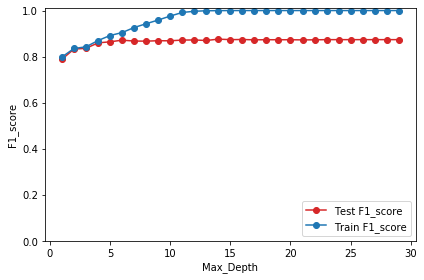

In [53]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Max_Depth')
ax1.set_ylabel('F1_score')
ax1.set_ylim([0,1.01])
ax1.plot(max_d, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(max_d, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [54]:
#min_samples_split
score=[]
score_train=[]
min_samples=[]
for i in range(1,10,2):
    min_samples.append(i/10)
    cforest = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=5,min_samples_split=i/10,random_state=1, n_jobs=2) #Creating Instance
    cforest.fit(X_train, y_train) #Learning the decision boundaries
    train_pred = cforest.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = cforest.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

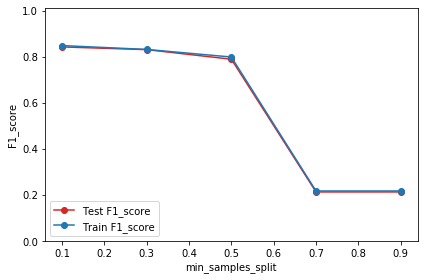

In [55]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('F1_score')
ax1.set_ylim([0,1.01])
ax1.plot(min_samples, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(min_samples, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Applying Model

In [56]:
cforest = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=5,random_state=1, n_jobs=2) #Creating Instance
cforest.fit(X_train, y_train) #Learning the decision boundaries
y_pred = cforest.predict(X_test)

In [57]:
#Compare against true labels (Accuracy)
print('Accuracy (generalization)',cforest.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',cforest.score(X_train,y_train)) #Accuracy (memorization)

Accuracy (generalization) 0.868448098663926
Accuracy (memorization) 0.8949468085106383


In [58]:
#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,cforest.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,cforest.predict(X_train),average="weighted")) #F1_score (memorization)  

F1_score (generalization) 0.8642612258012924
F1_score (memorization) 0.8916083187589872


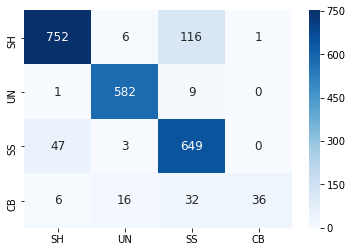

In [59]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_train, cforest.predict(X_train))

sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names) 

plt.show()

 1) GR                             0.448565
 2) NPHI                           0.372815
 3) RHOB                           0.135770
 4) RT                             0.042849


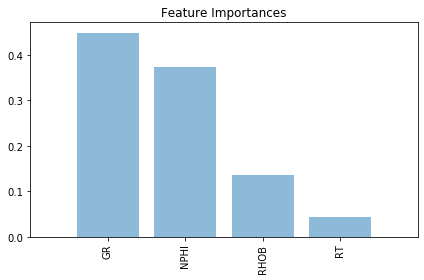

In [60]:
#Feature Importance
importances = cforest.feature_importances_
# get sort indices in descending order

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X.columns.values[indices[f]], importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),importances[indices],align='center',alpha=0.5)

plt.xticks(range(X_train.shape[1]), X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('fig-forest-feature-importances.png', dpi=300)
plt.show()

### 4.5 Multi-Layer Perceptron ( A Neural Network Implementation in Sklearn)

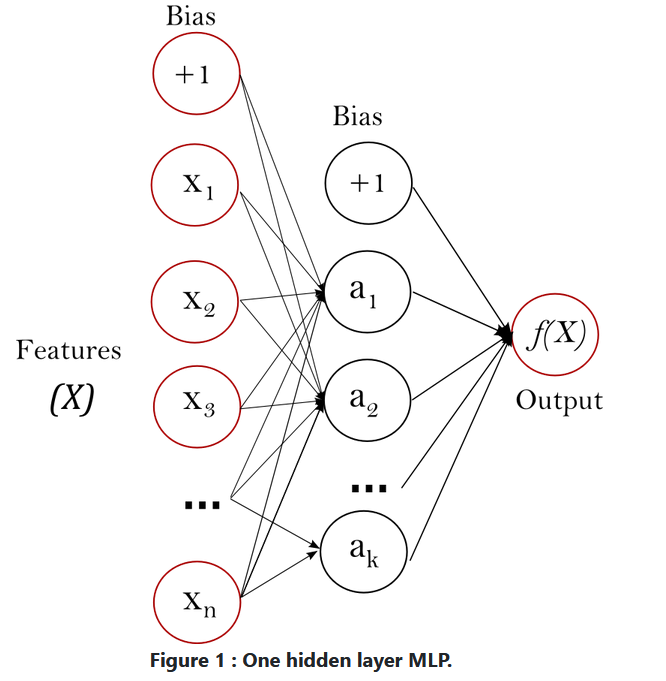

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips

#### Tuning Hyperparameters

In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV 

parameters = {'solver': ['lbfgs'], 'max_iter': [1000,1400,1800,2000,2500], 'alpha': 10.0 ** -np.arange(1, 5), 'hidden_layer_sizes':[10,20,50,100]}
MLPCla = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, refit=True, verbose=3)

In [62]:
MLPCla.fit(X_train, y_train)
print(MLPCla.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 27.5min finished


{'alpha': 0.1, 'hidden_layer_sizes': 20, 'max_iter': 1800, 'solver': 'lbfgs'}


#### Applying Model

In [63]:
MLPCla = MLPClassifier(solver='lbfgs', alpha=0.1, hidden_layer_sizes=(20,), max_iter=1000)
#MLPCla = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(100,), random_state=1)
MLPCla.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [64]:
#Performance (Accuracy)
print('Accuracy (generalization)',MLPCla.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',MLPCla.score(X_train,y_train)) #Accuracy (memorization)

#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,MLPCla.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,MLPCla.predict(X_train),average="weighted")) #F1_score (memorization) 

Accuracy (generalization) 0.8838643371017472
Accuracy (memorization) 0.9100177304964538
F1_score (generalization) 0.8840292089354403
F1_score (memorization) 0.9092055184863417


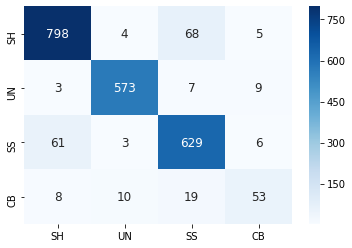

In [65]:
#Confusion Matrix
names = ['SH', 'UN', 'SS', 'CB']

cf_matrix = confusion_matrix(y_train, MLPCla.predict(X_train))

cf=sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names)

plt.show()

### 4.6 Naive Bayes

#### Tuning Hyperparameters

In [66]:
from sklearn.naive_bayes import GaussianNB

score=[]
score_train=[]
C=[]
for i in range(1,10,1):
    C.append(1*(10**(-i)))
    classifier = GaussianNB(var_smoothing=1*(10**(-i))) 
    classifier.fit(X_train, y_train)
    train_pred = classifier.predict(X_train)
    score_train.append(f1_score(y_train, train_pred,average="weighted"))
    y_pred = classifier.predict(X_test)
    score.append(f1_score(y_test, y_pred,average="weighted"))

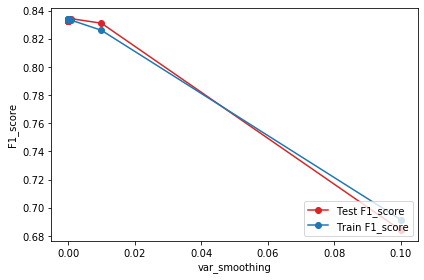

In [67]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('var_smoothing')
ax1.set_ylabel('F1_score')
ax1.plot(C, score, '-o',color=color,label='Test F1_score')

color = 'tab:blue'
ax1.plot(C, score_train, '-o',color=color,label='Train F1_score')

ax1.legend(loc="lower right")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Applying Model

In [68]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(var_smoothing = 0.01)
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=0.01)

In [69]:
#Performance (Accuracy)
print('Accuracy (generalization)',gnb.score(X_test,y_test)) #Accuracy (generalization)  
print('Accuracy (memorization)',gnb.score(X_train,y_train)) #Accuracy (memorization)

#Comparing other metrics (f1_score)
print('F1_score (generalization)',f1_score(y_test,gnb.predict(X_test),average="weighted")) #F1_score (generalization)  
print('F1_score (memorization)',f1_score(y_train,gnb.predict(X_train),average="weighted")) #F1_score (memorization) 

Accuracy (generalization) 0.8365878725590956
Accuracy (memorization) 0.8359929078014184
F1_score (generalization) 0.8310201042997911
F1_score (memorization) 0.8259911811346388


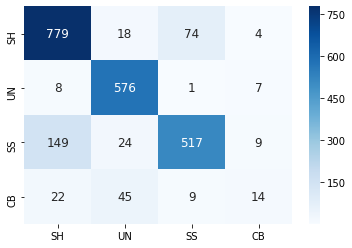

In [70]:
#Confusion Matrix
names = ['SH', 'UN', 'SS', 'CB']

cf_matrix = confusion_matrix(y_train, gnb.predict(X_train))

cf=sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12},cmap='Blues',fmt="d",xticklabels=names,yticklabels=names)

plt.show()

### 4.7. Scores for all classifiers

![Score_Classifiers_Volve](Score_Classifiers_Volve.png)

##### Additional Classifiers tested:

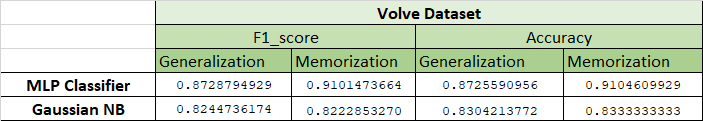

## 5. Deployment (Predict targets for new dataset)

In [71]:
well_13

,Well,GR,RT,RHOB,NPHI
Depth,,,,,
4175.5,13,20.6032,4.1812,2.6117,0.0770
4176.0,13,21.4990,4.5516,2.6131,0.0798
4176.5,13,22.4472,4.4804,2.6334,0.0801
4177.0,13,29.6713,4.3859,2.6328,0.1005
4177.5,13,34.7014,4.8566,2.6183,0.1001
...,...,...,...,...,...
4586.5,13,68.1668,1.3877,2.5219,0.1587
4587.0,13,71.9559,1.3800,2.5062,0.1739
4587.5,13,67.5752,1.3391,2.5030,0.1704


In [72]:
X = well_13.drop(['Well'], axis = 1) #Features: Feature vector

In [73]:
#Scaling
X_test = rscaler.transform(X)
X_test=pd.DataFrame(X_test,index=X.index, columns=X.columns)
X_test

,GR,RT,RHOB,NPHI
Depth,,,,
4175.5,-0.261732,0.850418,0.641084,-0.838991
4176.0,-0.243898,0.985685,0.646924,-0.817751
4176.5,-0.225020,0.959683,0.731595,-0.815475
4177.0,-0.081198,0.925173,0.729093,-0.660724
4177.5,0.018945,1.097068,0.668613,-0.663759
...,...,...,...,...
4586.5,0.685198,-0.169740,0.266528,-0.219230
4587.0,0.760634,-0.172552,0.201043,-0.103926
4587.5,0.673420,-0.187489,0.187696,-0.130476


In [74]:
well_13.reset_index(inplace = True)

### 5.1. Logistic Regression

In [75]:
y_pred=classifier.predict(X_test)
well_13['Prediction'] = y_pred
well_13['RT_log'] = np.log10(well_13.RT) #For Visualization
well_13

,Depth,Well,GR,RT,RHOB,NPHI,Prediction,RT_log
0,4175.5,13,20.6032,4.1812,2.6117,0.0770,CB,0.621301
1,4176.0,13,21.4990,4.5516,2.6131,0.0798,CB,0.658164
2,4176.5,13,22.4472,4.4804,2.6334,0.0801,CB,0.651317
3,4177.0,13,29.6713,4.3859,2.6328,0.1005,CB,0.642059
4,4177.5,13,34.7014,4.8566,2.6183,0.1001,CB,0.686332
...,...,...,...,...,...,...,...,...
822,4586.5,13,68.1668,1.3877,2.5219,0.1587,UN,0.142296
823,4587.0,13,71.9559,1.3800,2.5062,0.1739,SH,0.139879
824,4587.5,13,67.5752,1.3391,2.5030,0.1704,UN,0.126813
825,4588.0,13,65.0492,1.3286,2.4855,0.1754,UN,0.123394


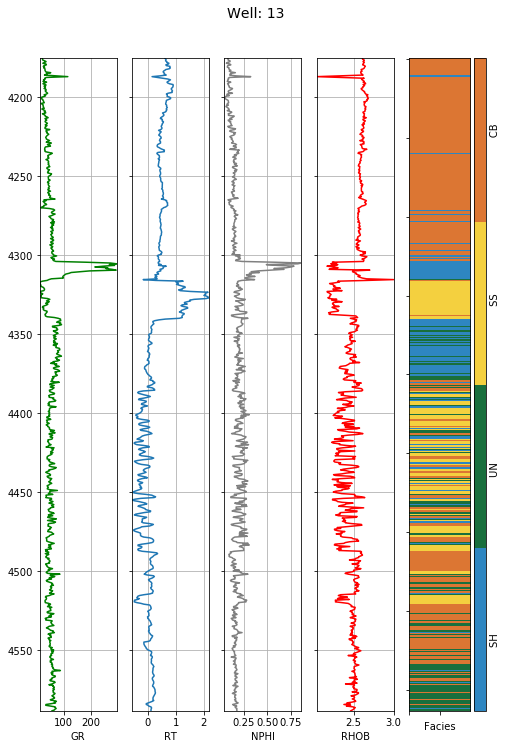

In [76]:
labels = [1,2,3,4] 
well_13['Facies_Label']=np.select([well_13['Prediction'] == 'SH',
                                well_13['Prediction'] == 'UN',
                                well_13['Prediction'] == 'SS',
                                well_13['Prediction'] == 'CB',]
                                ,labels)
make_facies_log_plot(well_13,facies_colors)

In [77]:
LR_well_13=well_13[['Depth','Prediction']]
LR_well_13.set_index('Depth',inplace=True)

### 5.2. K-Nearest Neighbor

In [78]:
y_pred=knn.predict(X_test)
well_13['Prediction'] = y_pred

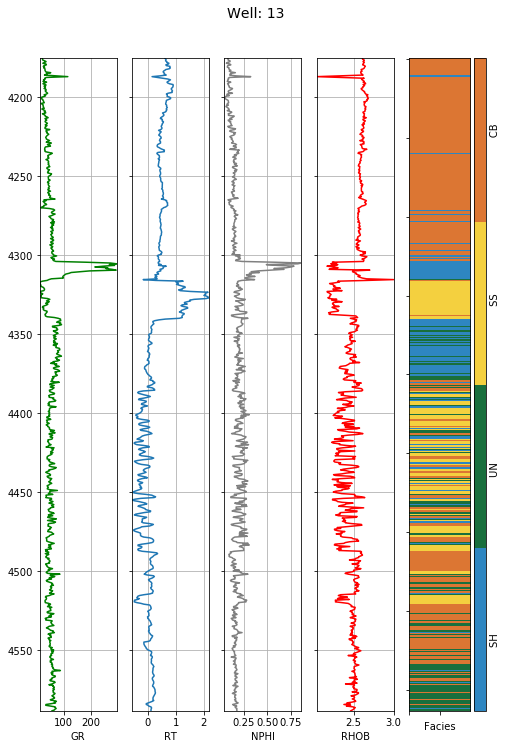

In [79]:
make_facies_log_plot(well_13,facies_colors)

In [80]:
KNN_well_13=well_13[['Depth','Prediction']]
KNN_well_13.set_index('Depth',inplace=True)

### 5.3. Support Vector Machine

In [81]:
y_pred = srbf.predict(X_test)
well_13['Prediction'] = y_pred

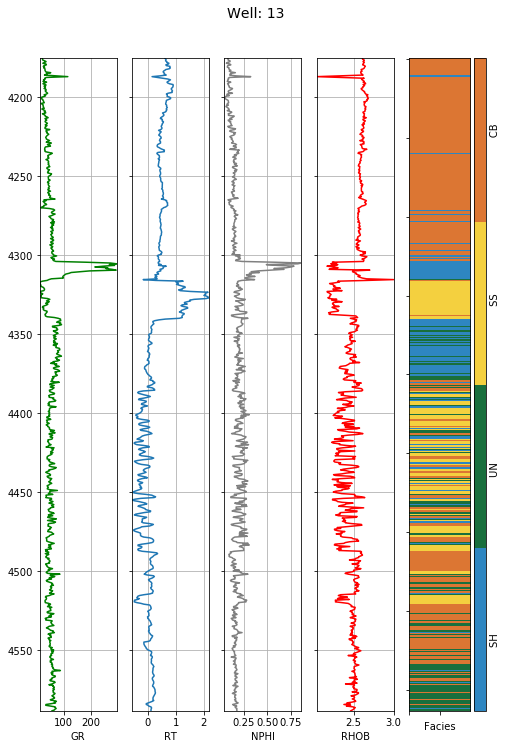

In [82]:
make_facies_log_plot(well_13,facies_colors)

In [83]:
SVC_well_13=well_13[['Depth','Prediction']]
SVC_well_13.set_index('Depth',inplace=True)

### 5.4. Random Forest

In [84]:
y_pred = cforest.predict(X_test)
well_13['Prediction'] = y_pred

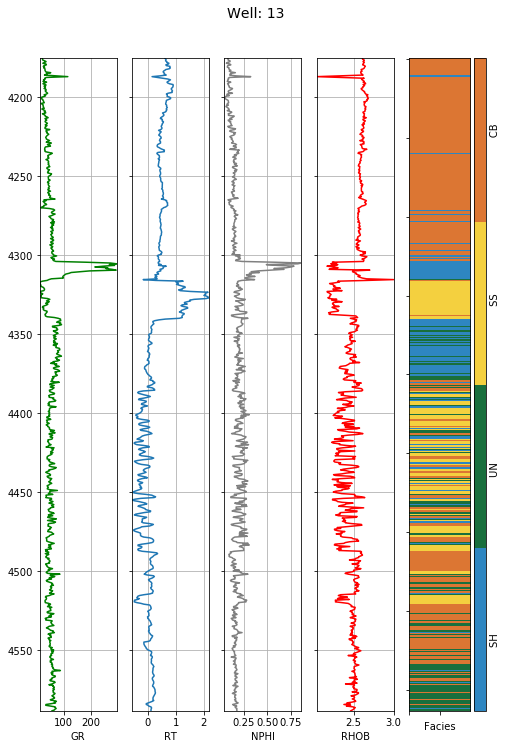

In [85]:
make_facies_log_plot(well_13,facies_colors)

In [86]:
RF_well_13=well_13[['Depth','Prediction']]
RF_well_13.set_index('Depth',inplace=True)

### 5.5. Multi-Layer Perceptron Classifier (A NN implementation in Sklearn)

In [87]:
y_pred = MLPCla.predict(X_test)
well_13['Prediction'] = y_pred

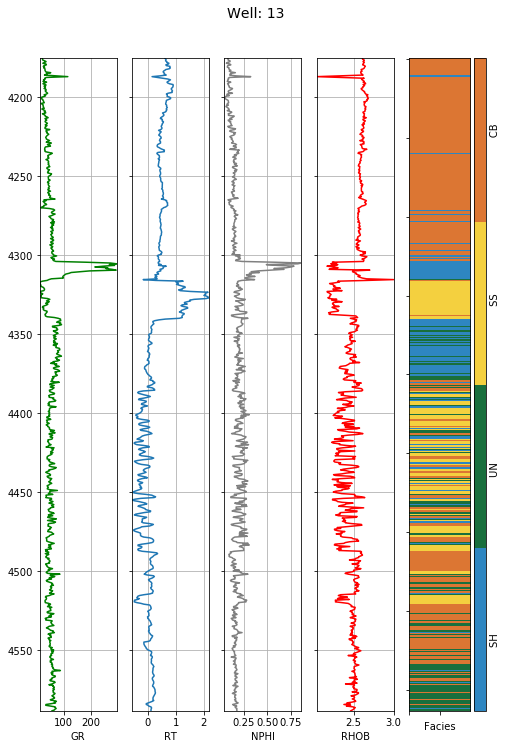

In [88]:
make_facies_log_plot(well_13,facies_colors)

In [89]:
MLP_well_13=well_13[['Depth','Prediction']]
MLP_well_13.set_index('Depth',inplace=True)

### 5.6. Naive Bayes

In [90]:
y_pred = gnb.predict(X_test)
well_13['Prediction'] = y_pred

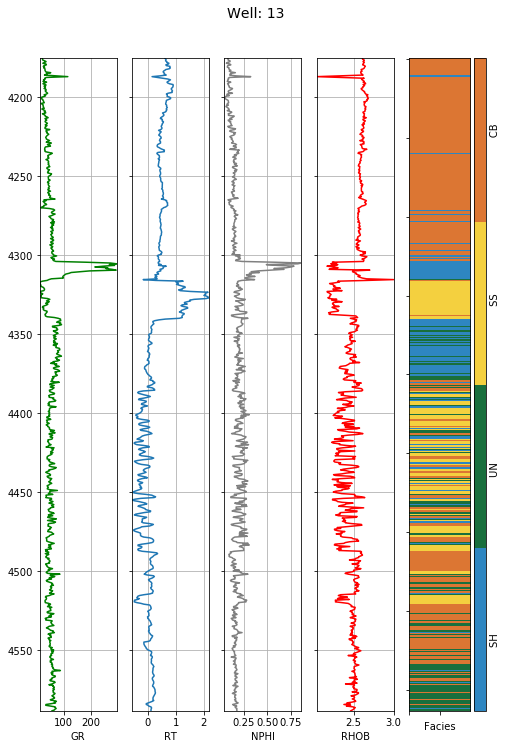

In [91]:
make_facies_log_plot(well_13,facies_colors)

In [92]:
GNB_well_13=well_13[['Depth','Prediction']]
GNB_well_13.set_index('Depth',inplace=True)

### 5.5. Facies Prediction (All classifiers)

In [93]:
models = [LR_well_13,KNN_well_13, SVC_well_13, RF_well_13, MLP_well_13, GNB_well_13]
facies_prediction = pd.concat(models,axis=1)
facies_prediction.columns=['Logistic Regression','K-Nearest Neighbor','SVC','Random Forest', 'MLP Classifier','Gaussian Naive Bayes']

In [94]:
facies_prediction

,Logistic Regression,K-Nearest Neighbor,SVC,Random Forest,MLP Classifier,Gaussian Naive Bayes
Depth,,,,,,
4175.5,CB,CB,CB,CB,CB,CB
4176.0,CB,CB,CB,CB,CB,CB
4176.5,CB,CB,CB,CB,CB,CB
4177.0,CB,CB,CB,CB,CB,CB
4177.5,CB,CB,CB,CB,CB,CB
...,...,...,...,...,...,...
4586.5,UN,SH,UN,SH,UN,SH
4587.0,SH,UN,UN,SH,SH,SH
4587.5,UN,CB,UN,SH,UN,SH


In [95]:
facies_prediction.to_excel('Facies_prediction.xlsx')